In [1]:
import tensorflow as tf
from utility.initialize_tf import *
from custom_models.gamornet_keras_module import *
from utility.data_loading import *
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from utility.display_prediction_results import *
from utility.data_preprocessing import *

2.5.0
2.5.0


In [2]:
training_data = "fd=0.3-0.7_hdf5"
transfer_data = "califa_s_1.0"
transfer_validation_split = 0.5
testing_data = "nair_abraham_2010_hdf5"

#trained_model_path = f"./saved_models/result_models/gamornet/trained_model_with_reg.hdf5"
trained_model_path = f'.\\saved_models\\result_models\\final\\gamornet\\sim_with_gaussian_noise\\trained_model_with_reg_new.hdf5'
transferred_model_path = f"./saved_models/result_models/final/gamornet/transfer_learning/transferred_model_with_reg_vs={transfer_validation_split}"
tuned_model_path = f"./saved_models/result_models/finalgamornet/transfer_learning/tuned_model_with_reg_vs={transfer_validation_split}"

In [ ]:
x_test, y_test, metadata = load_hdf5_data(name=testing_data)
x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=1)

sss = StratifiedShuffleSplit(n_splits=3, train_size=transfer_validation_split, random_state=2021)
#print(sss.get_n_splits(x_test, y_test))

In [ ]:
x_dataset, y_dataset, metadata = load_hdf5_data(name=training_data)
add_point_sources(x_dataset)
add_background_galaxies(x_dataset)
#apply_gaussian_PSF(x_dataset, 0.218598726) # General Gaussian PSF 0.218598726 0.573292215 1.3 20.84 8.85
add_gaussian_noise(x_dataset, noise_range=[0.01, 0.02])
apply_moffat_PSF(x_dataset, 4.148122, 4.765) #4.765 #g 0.65049197562297747917932881055243
#apply_gaussian_PSF(x_dataset, 0.02)
#apply_gaussian_PSF(x_dataset, 0.218598726)

In [ ]:
x_dataset = np.expand_dims(x_dataset, axis=3)
y_dataset = np.expand_dims(y_dataset, axis=1)
input_shape = x_dataset.shape[1:]
print(input_shape)

In [ ]:
base_model = gamornet_build_model_keras(input_shape=input_shape)

In [ ]:
base_model.summary()

In [ ]:
x_transfer, y_transfer, transfer_metadata = load_hdf5_data(transfer_data)
x_transfer = np.expand_dims(x_transfer, axis=3)
y_transfer = np.expand_dims(y_transfer, axis=1).astype(np.int32)
input_shape = x_transfer.shape[1:]
print(input_shape)

early_stopping_callback = ReturnBestEarlyStopping(monitor='val_sparse_categorical_accuracy', patience=50, restore_best_weights=True)
# x_train, x_val, y_train, y_val = train_test_split(x_dataset, y_dataset, shuffle=True, train_size=0.8, random_state=2021)
# _, x_val, _, y_val = train_test_split(x_transfer, y_transfer, shuffle=True, train_size=transfer_validation_split, random_state=2021)

x_train, x_val, y_train, y_val = train_test_split(x_dataset, y_dataset, shuffle=True, train_size=0.7, random_state=2021, stratify=y_dataset)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, shuffle=True, train_size=2/3, random_state=2021, stratify=y_val)

trained_model, train_history = gamornet_train_keras(x_train, y_train, x_val, y_val, input_shape=input_shape, epochs=200, callbacks=[early_stopping_callback], batch_size=256, lr=0.0005, decay=0.001)
plot_learning_curves(train_history)
trained_model.save(trained_model_path)
plot_model_results(trained_model, x_train, y_train, x_val, y_val, x_transfer, y_transfer)
#early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=2500, restore_best_weights=True)




In [3]:
early_stopping_callback = ReturnBestEarlyStopping(monitor='val_sparse_categorical_accuracy', patience=4900, restore_best_weights=True, verbose=1)

x_transfer, y_transfer, transfer_metadata = load_hdf5_data(transfer_data)
x_transfer = np.expand_dims(x_transfer, axis=3)
y_transfer = np.expand_dims(y_transfer, axis=1).astype(np.int32)
input_shape = x_transfer.shape[1:]
print(input_shape)

# x_train, x_val, y_train, y_val = train_test_split(x_transfer, y_transfer, shuffle=True, train_size=transfer_validation_split, random_state=2021)

# train_datagen = create_datagen(x_train)
# val_datagen = create_datagen(x_val)
# print(y_val[:5])

(79, 100, 100)
(100, 100, 1)


E:\Anaconda3\envs\hon-tf-2.5.0\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is a Python keyword: 'class'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [ ]:
for train_index, val_index in sss.split(x_transfer, y_transfer):
    plot_testing_results(trained_model.predict(x_transfer[val_index]).argmax(axis=1), y_transfer[val_index])

In [ ]:
# def create_datagen(subset):
#     from tensorflow.keras.preprocessing.image import ImageDataGenerator

#     datagen = ImageDataGenerator(
#         horizontal_flip=True,
#         vertical_flip=True,
#         #width_shift_range=0.2,
#         #height_shift_range=0.2,
#         zoom_range=[0.8, 1.2],
#         rotation_range=45,
#         fill_mode='wrap',
#         #cval = 0
#         #validation_split = 0.2
#     )
#     datagen.fit(subset)
#     return datagen

In [ ]:
# for i, (train_index, val_index) in enumerate(sss.split(x_transfer, y_transfer)):
#     train_datagen = create_datagen(x_transfer[train_index])
#     imgs = train_datagen.flow(x_transfer[train_index], y_transfer[train_index], batch_size=1024).next()
#     print(len(imgs[0]))
#     break

# Transfer Learning

In [ ]:
#trained_model_path = f"./saved_models/result_models/final/gamornet/sim_with_gaussian_noise/trained_model_with_gaussian_noise.hdf5"# REMOVE!!!
early_stopping_callback = ReturnBestEarlyStopping(monitor='val_sparse_categorical_accuracy', patience=4500, restore_best_weights=True)

for i, (train_index, val_index) in enumerate(sss.split(x_transfer, y_transfer)):
    train_datagen = create_datagen(x_transfer[train_index])
    val_datagen = create_datagen(x_transfer[val_index])
    transferred_model, transfer_history = gamornet_tl_keras(train_datagen, x_transfer[train_index], y_transfer[train_index], val_datagen, x_transfer[val_index], y_transfer[val_index], 
        input_shape = input_shape, model_load_path=trained_model_path, load_layers_bools="load_bools_SDSS", trainable_bools="train_bools_SDSS", 
        files_save_path="./saved_models/gamornet/", loss='sparse_categorical_crossentropy', epochs=5000, callbacks=[early_stopping_callback], batch_size=256, lr=0.0005, decay=0.001)#, #lr=0.00001)#epochs=719)
    plot_learning_curves(transfer_history)
    transferred_model.save(f"{transferred_model_path}_skf={i}.hdf5", save_traces=True)

In [ ]:
# for i, (train_index, val_index) in enumerate(sss.split(x_transfer, y_transfer)):
#     model = tf.keras.models.load_model(f"{transferred_model_path}_skf={i}.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
#     plot_testing_results(model.predict(x_transfer[val_index]).argmax(axis=1), y_transfer[val_index])

In [ ]:
for i, (train_index, val_index) in enumerate(sss.split(x_transfer, y_transfer)):
    train_datagen = create_datagen(x_transfer[train_index])
    val_datagen = create_datagen(x_transfer[val_index])
    tuned_model, tuning_history = gamornet_tl_keras(train_datagen, x_transfer[train_index], y_transfer[train_index], val_datagen, x_transfer[val_index], y_transfer[val_index],
        input_shape = input_shape, model_load_path=f"{transferred_model_path}_skf={i}.hdf5", 
        load_layers_bools="train_bools_SDSS", 
        trainable_bools="train_bools_SDSS",
        files_save_path="./saved_models/gamornet/", batch_size=128, loss='sparse_categorical_crossentropy', epochs=5000, lr=0.000005, callbacks=[early_stopping_callback])
    plot_learning_curves(tuning_history)
    tuned_model.save(f"{tuned_model_path}_skf={i}.hdf5", save_traces=True)

In [ ]:
for i, (train_index, val_index) in enumerate(sss.split(x_transfer, y_transfer)):
    model = tf.keras.models.load_model(f"{tuned_model_path}_skf={i}.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
    plot_testing_results(model.predict(x_transfer[val_index]).argmax(axis=1), y_transfer[val_index])

In [ ]:
# trained_model = tf.keras.models.load_model(f"{trained_model_path}", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
# for train_index, val_index in sss.split(x_transfer, y_transfer):
#     plot_model_results(trained_model, x_transfer[train_index], y_transfer[train_index], x_transfer[val_index], y_transfer[val_index], x_transfer, y_transfer)


In [ ]:
transferred_training_results = []
transferred_validation_results = []
for i, (train_index, val_index) in enumerate(sss.split(x_transfer, y_transfer)):
    transferred_model = tf.keras.models.load_model(f"{transferred_model_path}_skf={i}.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
    #plot_model_results(transferred_model, x_transfer[train_index], y_transfer[train_index], x_transfer[val_index], y_transfer[val_index], x_transfer, y_transfer)
    transferred_training_results.append(get_results(transferred_model, x_transfer[train_index], y_transfer[train_index]))
    transferred_validation_results.append(get_results(transferred_model, x_transfer[val_index], y_transfer[val_index]))
plot_results(transferred_training_results, title="Transfer Learning: GaMorNet; Training Confusion Matrix")
plot_results(transferred_validation_results, title="Transfer Learning: GaMorNet; Validation Confusion Matrix")


In [ ]:
tuned_training_results = []
tuned_validation_results = []
for i, (train_index, val_index) in enumerate(sss.split(x_transfer, y_transfer)):
    tuned_model = tf.keras.models.load_model(f"{tuned_model_path}_skf={i}.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
    #plot_model_results(tuned_model, x_transfer[train_index], y_transfer[train_index], x_transfer[val_index], y_transfer[val_index], x_transfer, y_transfer)
    tuned_training_results.append(get_results(tuned_model, x_transfer[train_index], y_transfer[train_index]))
    tuned_validation_results.append(get_results(tuned_model, x_transfer[val_index], y_transfer[val_index]))
plot_results(tuned_training_results, title="Transfer Learning: GaMorNet; Training Confusion Matrix")
plot_results(tuned_validation_results, title="Transfer Learning: GaMorNet; Validation Confusion Matrix")


In [4]:
transferred_model_path = f"./saved_models/result_models/final/gamornet/transfer_learning/transferred_model_with_reg"
tuned_model_path = f"./saved_models/result_models/final/gamornet/transfer_learning/tuned_model_with_reg"

#train_datagen = create_datagen(x_transfer)
#complete_transferred_model, complete_transfer_history = gamornet_tl_keras(train_datagen, x_transfer, y_transfer, None, x_transfer, y_transfer, 
#    input_shape = input_shape, model_load_path=trained_model_path, load_layers_bools="load_bools_SDSS", trainable_bools="train_bools_SDSS", 
#    files_save_path="./saved_models/gamornet/", loss='sparse_categorical_crossentropy', epochs=5000, callbacks=[], batch_size=256, lr=0.0005, decay=0.001)#, #lr=0.00001)#epochs=719)
# plot_learning_curves(complete_transfer_history)
# complete_transferred_model.save(f"{transferred_model_path}_complete.hdf5", save_traces=True)

[True, True, True, True, True, True, True, True]
Loading Layer0 from previous model.
Loading Layer5 from previous model.
Loading Layer10 from previous model.
Loading Layer12 from previous model.
Loading Layer14 from previous model.
Loading Layer20 from previous model.
Loading Layer23 from previous model.
Loading Layer26 from previous model.
1/1 [==============================] - 7s 7s/step - loss: 47.3806 - sparse_categorical_accuracy: 0.8228 - accuracy: 0.5696 - val_loss: 47.1384 - val_sparse_categorical_accuracy: 0.9494 - val_accuracy: 0.5443


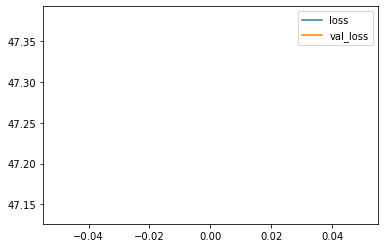

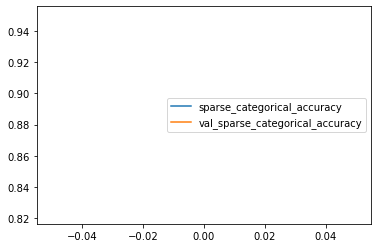

In [5]:
train_datagen = create_datagen(x_transfer)
complete_tuned_model, complete_tuning_history = gamornet_tl_keras(train_datagen, x_transfer, y_transfer, None, x_transfer, y_transfer,
    input_shape = input_shape, model_load_path=f"{transferred_model_path}_complete.hdf5", 
    load_layers_bools=[True] * 8, 
    trainable_bools=[True] * 8,
    files_save_path="./saved_models/gamornet/", batch_size=128, loss='sparse_categorical_crossentropy', epochs=35, lr=0.000005, callbacks=[])
plot_learning_curves(complete_tuning_history)
complete_tuned_model.save(f"{tuned_model_path}_complete.hdf5", save_traces=True)

In [ ]:
complete_tuned_model.summary()

In [ ]:
#o = get_results(complete_transferred_model, x_transfer, y_transfer)
c = get_results(complete_tuned_model, x_transfer, y_transfer)
#plot_results(o, title="Transfer Learning: GaMorNet; Training Confusion Matrix")
plot_results(c, title="Transfer Learning: GaMorNet; Validation Confusion Matrix")

In [ ]:
transferred_model = tf.keras.models.load_model(f"{transferred_model_path}_complete.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
c = get_results(transferred_model, x_transfer, y_transfer)
plot_results(c, title="Transfer Learning: GaMorNet; Validation Confusion Matrix")
print(len(transferred_model.layers))

27


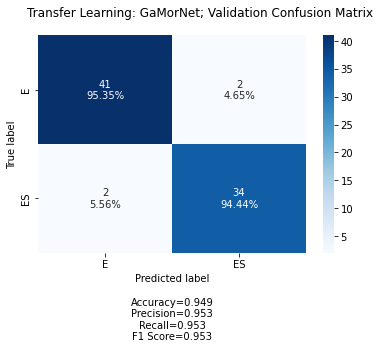

In [6]:
tuned_model = tf.keras.models.load_model(f"{tuned_model_path}_complete.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
c = get_results(tuned_model, x_transfer, y_transfer)
plot_results(c, title="Transfer Learning: GaMorNet; Validation Confusion Matrix")
print(len(tuned_model.layers))